# Valuing American Options by Simulation: A Simple Least-Square Approach

Implementation by Python

For an American option, the optimal strategy to exercise is to compare the immediate exercise value with the expected cash flows from continuing. Thus, The key to optimally exercising an American option is identifying the conditional expected value of continuation.


$ dS = \mu Sdt + \sigma SdZ $

The formula for calculating stock price at time t is:

$ S_{t_{i+1}} = S_{t_{i}} e^{(\mu - \frac{1}{2}\sigma^2)(t_{i+1}-t_{i})+\sigma \sqrt{t_{i+1}-t_{i}} Z_{i+1}} $,
where $Z \sim N(0, 1)$

In [427]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

In [428]:
'''    
parameter description:
S0: initial price
n: number of steps
t: starting time
T: terminating time
St: trajectory of price
a, b: the first and second moment of log Y
d: dividend yield
'''

def Geometric_Brownian_Motion_Trajectory( mu, sigma, S0, n, t, T ): 
    time = np.linspace(t, T, n + 1) 
    delta_time = time[1] - time[0] 
    St = np.zeros(n + 1)
    St[0] = S0
    z = np.random.standard_normal(n) 
    for i in range(n):
        St[i + 1] = St[i] * np.exp((mu - 1 / 2 * sigma ** 2) * delta_time + sigma * delta_time ** (1 / 2) * z[i])
    return St

def Geometric_Brownian_Motion_Jump( mu, sigma, d, S0, n, t, T, a, b, lam ):
        
    delta_t = (T - t) / n
    St = np.zeros(n + 1)
    X = np.zeros(n + 1)
    z = np.random.normal(size=(n + 1, 1))
    X[0] = np.log(S0)
    for i in range(1, n + 1):
        n = np.random.poisson(lam * delta_t)
        if n == 0:
            m =0 
        else:
            m = a * n + b * n ** 0.5 * np.random.normal()
        X[i] = X[i - 1] + (mu - d - 0.5 * sigma ** 2) * delta_t + sigma * delta_t ** 0.5 * z[i] + m
        St = np.exp(X)
    return St


In [429]:
S0 = [36, 38, 40, 42, 44]
K = 40
r = 0.06
sigma = [0.2, 0.4]
t = 0
T = [1, 2]
n = 50 # 50 steps per year
m = 10000 # 10000 paths of stock price

Text(0.5,1,'Monte Carlo Simulation for Stock Price')

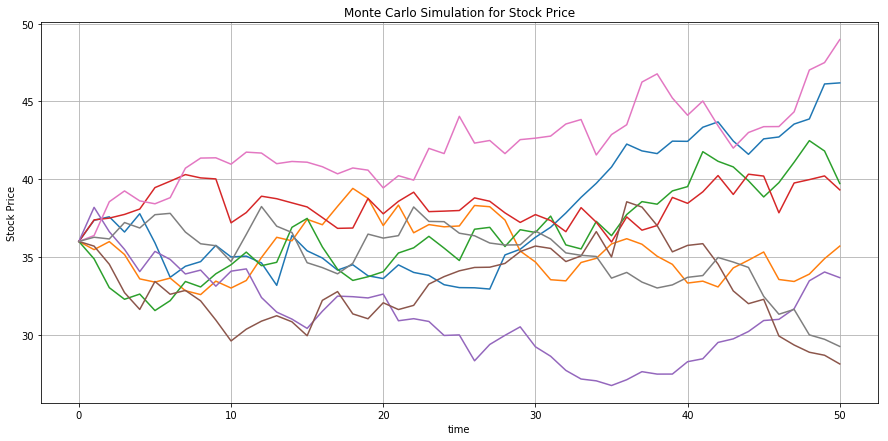

In [430]:
terminating_value = []

fig = plt.figure(figsize=(15, 7))
for i in range(8):
    GeoBro = Geometric_Brownian_Motion_Trajectory( r, sigma[0], S0[0], n, t, T[0] )
    plt.plot(GeoBro)
    terminating_value.append(GeoBro[-1])

plt.grid(True)
plt.axis('tight')
plt.ylabel('Stock Price')
plt.xlabel('time')
plt.title('Monte Carlo Simulation for Stock Price')


In [434]:
St_GeoBro = np.zeros((8, n+1))
for i in range(8):
    St_GeoBro[i, :] = Geometric_Brownian_Motion_Trajectory( r, sigma[0], S0[0], n, t, T[0] )

Cash_Flow = np.zeros((8, n+1))
Cash_Flow = np.maximum( K - St_GeoBro, 0 )

Cash_Flow[:, n]

Cash_Flow[:, n-1]

K - St_GeoBro[:, n-1] 

K - St_GeoBro[:, n-1] > 0

X = (K - St_GeoBro[:, n-1])[K - St_GeoBro[:, n-1] > 0]

Y = ( np.maximum( K - St_GeoBro[:, n], 0 ) * np.exp( -r * 1/50) )[K - St_GeoBro[:, n-1] > 0]

X = X.reshape(np.size(X),1)

X2 = (X**2).reshape(np.size(X**2),1)

XX = np.hstack((X,X2))

reg = LinearRegression().fit(XX, Y)

Y_predict = reg.predict(XX)

exercise = (Y_predict < Cash_Flow[K - St_GeoBro[:, n-1] > 0, n-1]) * Cash_Flow[K - St_GeoBro[:, n-1] > 0, n-1]

Cash_Flow[K - St_GeoBro[:, n-1] > 0, n-1] = exercise

Cash_Flow[(Cash_Flow[:, n-1] > 0), n] = 0

In [435]:
S0 = 36
K = 40
r = 0.06
sigma = 0.2
t = 0
T = 1
n = 3 # 50 steps per year
m = 8 # 10000 paths of stock price

In [436]:
def Valuation_by_Least_Square( r, sigma, S0, m, n, t, T ):
    # Create m paths of stock price with n steps of time by simulation
    St_GeoBro = np.zeros((m, n+1))
    for i in range(m):
        St_GeoBro[i, :] = Geometric_Brownian_Motion_Trajectory( r, sigma, S0, n, t, T )

    # Payoff is a matrix of the amount of cash flow at each step if immediately exercising the option,
    # which is only for convenience of calculation in the following procedures 
    Payoff = np.maximum( K - St_GeoBro, 0 )
        
    # Cash_Flow is a matrix similar to Payoff, 
    # which is updated by doing regression and deciding whether to exercise immediately
    Cash_Flow = np.maximum( K - St_GeoBro, 0 )

    # Calculate the conditional expected value of continuation
    # 1. regressing (Y = the discounted payoff at time t_i+1) against (X = the stock price, whose option is in the money at time t_i) and X^2
    # 2. predict the expected conditional value at time t_i by substituing X and X^2 into the regression formula
    # 3. compare the expected conditional value with the immediate value
    # 4. if the immediate value is greater, exercise immediately

    for i in range(n-1):
    
        # X is the payoff if exercise in the money at time t_i
        X = ( Payoff[:, n-1-i] )[ Payoff[:, n-1-i] > 0 ]

        # Y is the discounted payoff at time t_i+1, related to X
        Y = ( Payoff[:, n-i] )[ Payoff[:, n-1-i] > 0 ] * np.exp( -r * 1/n * (i+1) )

        # L0, L1, L2 are basis functions of X
        # combine them into a single matrix for following regression 
        X = X.reshape(np.size(X),1)
        L0 = np.exp( -X/2 )
        L1 = L0 * ( 1 - X )
        L2 = L0 * ( 1 - 2*X + X**2/2 )
        XX = np.hstack((L0, L1, L2))

        # regress Y ~ intercept + a * X + b * X2
        reg = LinearRegression().fit(XX, Y)
        # calculate the predicted value of Y (i.e. the conditional expected value of continuation)
        Y_predict = reg.predict(XX)

        # compare the immediate exercise value with the conditional expected value of continuation
        # and decide whether to exercise immediately
        exercise = ( Y_predict < Payoff[ Payoff[:, n-1-i] > 0, n-1-i ] ) * Payoff[ Payoff[:, n-1-i] > 0, n-1-i ]

        # substitue those values decided to exercise immediately into the Cash_Flow matrix
        # and set the continuing values of Cash_Flow to zero, as the option is exercised obly once
        Cash_Flow[ Payoff[:, n-1-i] > 0, n-1-i ] = exercise
        Cash_Flow[ Payoff[:, n-1-i] > 0, n-i: ] = 0
    
    # calculate the discounted factor matrix
    df = np.ones(np.shape(Cash_Flow[:, 1:]))
    for i in range(n):
        df[:, i] = np.exp( -r * 1/n * (i+1))
    
    # calculate the present value of each path
    PV_of_Cash_Flow = np.sum( (Cash_Flow[:, 1:] * df), axis=1 )
    
    # calculate the value of the option
    # by averaging the value of each presen value of each path
    value = np.mean(PV_of_Cash_Flow)
    
    return value

In [433]:
Value = Valuation_by_Least_Square( r, sigma, S0, m, n, t, T )
Value

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()